In [19]:
from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from qutip import Qobj, tensor, basis, sesolve, expect, qeye, destroy
from qutip import mesolve
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [33]:
# ===== 1. 手动构造 H₂O 分子的哈密顿量 =====
fermionic_ham = FermionOperator()                       #初始化一个空的费米子哈密顿量
fermionic_ham += FermionOperator('', -0.81261)          #这是 常数项，代表核间排斥能 + 电子能的偏移项。
# 这些是单电子项（one-body terms).
# p^ p表示电子从轨道 p 湮灭并重新创建（等于存在于轨道 p 的概率).
# 系数是该轨道对应的能量，源自量子化学计算.
fermionic_ham += FermionOperator('0^ 0', -1.25248)
fermionic_ham += FermionOperator('1^ 1', -0.47595)
fermionic_ham += FermionOperator('2^ 2', -0.47595)
fermionic_ham += FermionOperator('3^ 3', -1.25248)
# 这些是双电子项（two-body terms），表示电子间库仑排斥.
# 格式 p^ q^ r s 代表：电子从 r 和 s 两个轨道中被湮灭，同时在 p 和 q 中被创建.
# 这是对电子间相互作用的建模，来源于积分项 ℎ_pqrs
fermionic_ham += FermionOperator('0^ 1^ 1 0', 0.67449)
fermionic_ham += FermionOperator('0^ 2^ 2 0', 0.66458)
fermionic_ham += FermionOperator('0^ 3^ 3 0', 0.18129)
fermionic_ham += FermionOperator('1^ 2^ 2 1', 0.18129)
fermionic_ham += FermionOperator('1^ 3^ 3 1', 0.66458)
fermionic_ham += FermionOperator('2^ 3^ 3 2', 0.67449)
# 这是交换项（exchange interaction），也属于双电子项，但构型不同,通常用于耦合两个 Slater 行列式之间的跃迁。
fermionic_ham += FermionOperator('0^ 1^ 2 3', 0.66347)
fermionic_ham += FermionOperator('3^ 2^ 1 0', 0.66347)


In [ ]:
# ===== 2. BK 映射为泡利哈密顿量 =====
n_qubits = 4
qubit_ham = bravyi_kitaev(fermionic_ham)

def qubit_operator_to_qutip(qubit_op, n_qubits):           #把 OpenFermion 的 QubitOperator 转换成 QuTiP 的 Qobj 矩阵。
    pauli_map = {'X': Qobj([[0, 1], [1, 0]]),              #定义 2x2 的 Pauli 矩阵，用 QuTiP 的 Qobj 表示。
                 'Y': Qobj([[0, -1j], [1j, 0]]),
                 'Z': Qobj([[1, 0], [0, -1]]),
                 'I': Qobj([[1, 0], [0, 1]])}
    H = 0
    for term, coeff in qubit_op.terms.items():             #初始化为单位矩阵（I），把对应 qubit 替换为 X/Y/Z，准备张量积。
        ops = [pauli_map['I']] * n_qubits
        for idx, op in term:
            ops[idx] = pauli_map[op]
        H += coeff * tensor(ops)                           #对每个项求张量积后乘系数，加到总哈密顿量上。
    return H

H_el = qubit_operator_to_qutip(qubit_ham, n_qubits)

#### 第二步想把前面手动构造的电子哈密顿量（fermionic_ham），先通过 Bravyi-Kitaev 映射 → 得到 qubit_ham（Pauli 算符组合），然后把它变成可用于模拟的 Qobj（矩阵表示）。准备好用于模拟电子部分动力学的矩阵表达。

In [ ]:
# ===== 3. 构建三个振动模式（简谐振子） =====
n1, n2, n3 = 4, 4, 4                                             #每个振动模的能级截断维度（最多保留前 4 个 Fock 态）。简谐振子理论上能级无限大，这里为了可模拟，截断为 4。
w1, w2, w3 = 1.0, 0.7, 1.2                                       #每个振动模的频率（ω₁、ω₂、ω₃），单位一般是原子单位（a.u.）
a1, a2, a3 = destroy(n1), destroy(n2), destroy(n3)               #创建 3 个降阶算符 a（QuTiP 中的 destroy(n)），用来构造哈密顿量 𝐻=𝜔𝑎†𝑎
#构造 𝐻_vib=∑𝑖=1——3𝜔_𝑖𝑎_𝑖†𝑎_𝑖,使用 tensor 构建三个 Hilbert 空间张量积             
H_vib = (tensor(w1 * a1.dag() * a1, qeye(n2), qeye(n3)) +
          tensor(qeye(n1), w2 * a2.dag() * a2, qeye(n3)) +
          tensor(qeye(n1), qeye(n2), w3 * a3.dag() * a3))
H_vib_ext = tensor(qeye(2 ** n_qubits), H_vib)                    #扩展到整个系统空间（电子空间 × 振动空间）,因为电子部分用了 n_qubits = 4 个 qubit（维度 16）,所以我们在整个 Hilbert 空间中构造 电子 + 振动模的组合系统.
H_vib_ext.dims = [[2]*n_qubits + [n1, n2, n3], [2]*n_qubits + [n1, n2, n3]] #设置 Qobj 的维度，确保兼容 QuTiP 的张量积系统表示

#### 我们要模拟 H₂O 的 三个分子振动模式（称为 normal modes），v1：对称伸缩振动，v2：弯曲振动，v3：不对称伸缩振动。这三个振动模式本质是三个独立的 简谐振子（harmonic oscillator）。

In [ ]:
# ===== 4. 构建耦合项（JC型）: σ₋ a† + σ₊ a =====
g1, g2, g3 = 0.5, 0.3, 0.4                             #三个耦合强度参数 𝑔_𝑖
sigmap = Qobj([[0, 1], [0, 0]])
sigmam = Qobj([[0, 0], [1, 0]])
#构建三个电子子的升/降算符（分别对应 qubit 0/1/2）
s1p = tensor(sigmap, qeye(2), qeye(2), qeye(2))        # qubit0 的 σ⁺
s1m = tensor(sigmam, qeye(2), qeye(2), qeye(2))        # qubit0 的 σ⁻
s2p = tensor(qeye(2), sigmap, qeye(2), qeye(2))        # qubit1 的 σ⁺
s2m = tensor(qeye(2), sigmam, qeye(2), qeye(2))        # qubit1 的 σ⁻
s3p = tensor(qeye(2), qeye(2), sigmap, qeye(2))        # qubit2 的 σ⁺
s3m = tensor(qeye(2), qeye(2), sigmam, qeye(2))        # qubit2 的 σ⁻
#构建 JC 型耦合项（每个 qubit ↔ 对应振动模）
H_int = tensor(s1p, a1.dag(), qeye(n2), qeye(n3)) + tensor(s1m, a1, qeye(n2), qeye(n3))
H_int += tensor(s2p, qeye(n1), a2.dag(), qeye(n3)) + tensor(s2m, qeye(n1), a2, qeye(n3))
H_int += tensor(s3p, qeye(n1), qeye(n2), a3.dag()) + tensor(s3m, qeye(n1), qeye(n2), a3)
H_int *= g1  # 可根据模式分开调节


#### g是耦合强度参数，也就是电子态与振动模式之间相互作用强度的度量
#### 我们为什么需要这个参数？是因为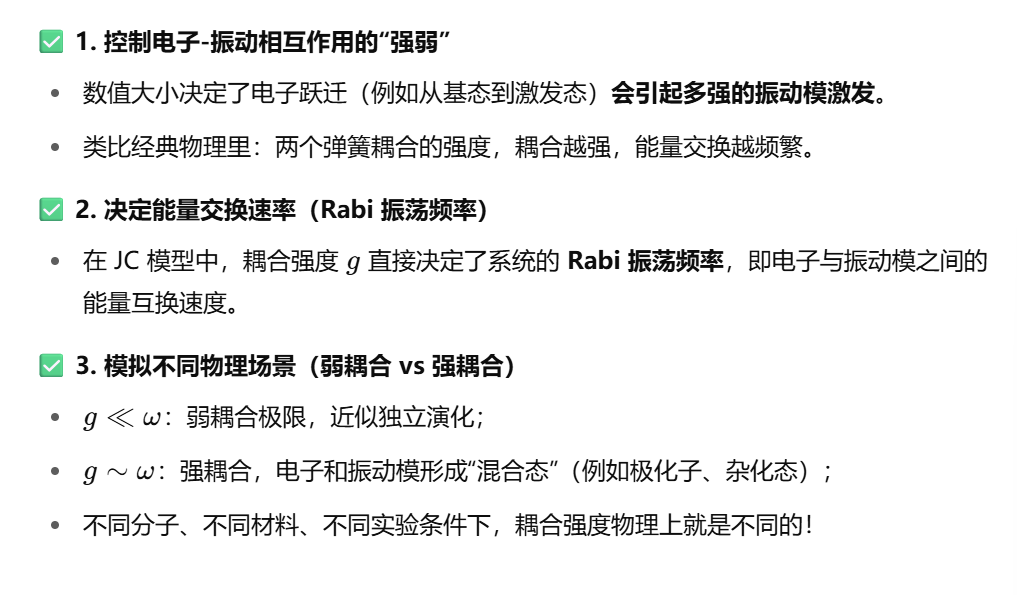
#### 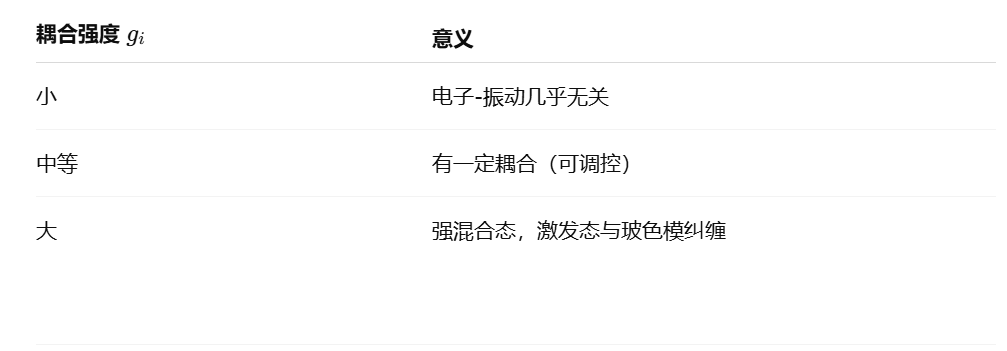

In [30]:
# ===== 5. 构造总哈密顿量 H_tot =====
H_el_ext = tensor(H_el, qeye(n1), qeye(n2), qeye(n3))
H_el_ext.dims = [H_el.dims[0] + [n1, n2, n3], H_el.dims[1] + [n1, n2, n3]]
H_tot = H_el_ext + H_vib_ext + H_int

In [31]:
# ===== 6. 初始态 =====
psi_el = tensor([basis(2, 0) for _ in range(n_qubits)])
psi_vib = tensor(basis(n1, 0), basis(n2, 0), basis(n3, 0))
psi0 = tensor(psi_el, psi_vib)

In [32]:
# ===== 7. 加入 T1 和 T2 噪声（玻色模） =====
T1_1, T1_2 = 20.0, 25.0
T2_1, T2_2 = 15.0, 18.0

gamma1 = 1.0 / T1_1
gamma2 = 1.0 / T1_2
phi1 = 1.0 / T2_1
phi2 = 1.0 / T2_2

a1_op = tensor(qeye(2**n_qubits), a1, qeye(n2), qeye(n3))
a2_op = tensor(qeye(2**n_qubits), qeye(n1), a2, qeye(n3))
a1_phi = tensor(qeye(2**n_qubits), a1.dag() * a1, qeye(n2), qeye(n3))
a2_phi = tensor(qeye(2**n_qubits), qeye(n1), a2.dag() * a2, qeye(n3))

c_ops = [np.sqrt(gamma1) * a1_op, np.sqrt(gamma2) * a2_op,
         np.sqrt(phi1) * a1_phi, np.sqrt(phi2) * a2_phi]


In [ ]:
# ===== 8. 动力学演化与观测 =====
tlist = np.linspace(0, 25, 300)
result = mesolve(H_tot, psi0, tlist, c_ops=c_ops)


MemoryError: Unable to allocate 16.0 TiB for an array with shape (1024, 1024, 1024, 1024) and data type complex128

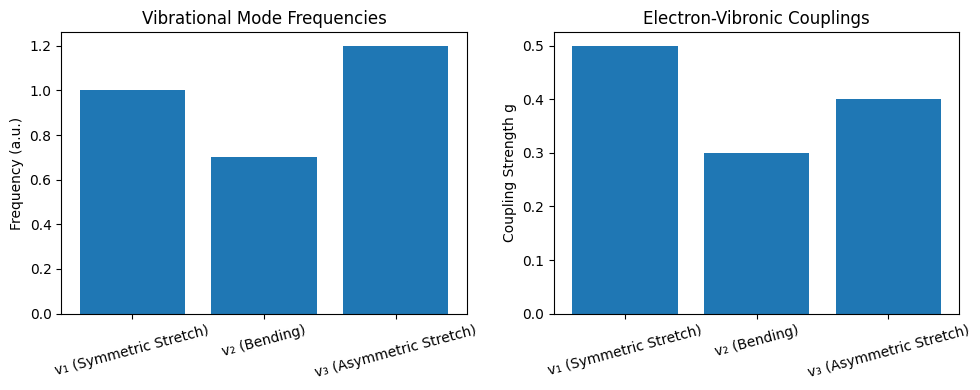

In [ ]:
# ===== 9. 可视化频率和耦合强度 =====
freqs = [w1, w2, w3]
couplings = [g1, g2, g3]
labels = ["v₁ (Symmetric Stretch)", "v₂ (Bending)", "v₃ (Asymmetric Stretch)"]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(labels, freqs)
plt.title("Vibrational Mode Frequencies")
plt.ylabel("Frequency (a.u.)")
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
plt.bar(labels, couplings)
plt.title("Electron-Vibronic Couplings")
plt.ylabel("Coupling Strength g")
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

In [ ]:
# ===== 10. 振动模式动图展示 =====
a1_op = tensor(qeye(2**n_qubits), a1 + a1.dag(), qeye(n2), qeye(n3))
a1_op.dims = [[2]*n_qubits + [n1, n2, n3], [2]*n_qubits + [n1, n2, n3]]
a2_op = tensor(qeye(2**n_qubits), qeye(n1), a2 + a2.dag(), qeye(n3))
a2_op.dims = [[2]*n_qubits + [n1, n2, n3], [2]*n_qubits + [n1, n2, n3]]
a3_op = tensor(qeye(2**n_qubits), qeye(n1), qeye(n2), a3 + a3.dag())
a3_op.dims = [[2]*n_qubits + [n1, n2, n3], [2]*n_qubits + [n1, n2, n3]]

a1_expect = expect(a1_op, result.states)
a2_expect = expect(a2_op, result.states)
a3_expect = expect(a3_op, result.states)

fig, ax = plt.subplots(figsize=(5, 4))
line1, = ax.plot([], [], 'r-', lw=2, label='v₁')
line2, = ax.plot([], [], 'b-', lw=2, label='v₂')
line3, = ax.plot([], [], 'g-', lw=2, label='v₃')
ax.set_xlim(-1, 1)
ax.set_ylim(-2, 2)
ax.legend()
ax.set_title("Vibrational Modes Animation")
ax.set_xlabel("Dimensionless coordinate")
ax.set_ylabel("Vibrational displacement")

x = np.linspace(-1, 1, 100)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

def animate(i):
    t = tlist[i]
    line1.set_data(x, np.sin(2 * np.pi * w1 * t) * np.exp(-x**2))
    line2.set_data(x, np.sin(2 * np.pi * w2 * t + np.pi/2) * np.exp(-x**2))
    line3.set_data(x, np.sin(2 * np.pi * w3 * t + np.pi) * np.exp(-x**2))
    return line1, line2, line3

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(tlist), interval=50, blit=True)
HTML(ani.to_jshtml())

NameError: name 'result' is not defined